In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

In [3]:
cities = pd.read_csv('aseancities.csv')  
ref_cities=pd.read_csv('reference_cities.csv')
database=pd.read_csv('worldcities.csv')

In [4]:
ref_cities.replace(u'\xa0',u'', regex=True, inplace=True)
ref_cities['Population'] = (ref_cities['Population'].str.split()).apply(lambda x: float(x[0].replace(',', '')))

In [5]:
ref_cities.head()

,Ranking,Name,Country,Population,Year (Census or Estimate)
0,1,Delhi,India,46960000.0,2014
1,2,Tokyo,Japan,39800000.0,2014
2,3,Mumbai,India,25000000.0,2014
3,4,Seoul,South Korea,24800000.0,2014
4,5,Shanghai,China,31100000.0,2014


In [6]:
cities=pd.concat([cities,ref_cities])

In [7]:
cities.drop(['Year (Census or Estimate)'],axis=1, inplace = True)

In [8]:
cities_merged = cities.join(database.set_index('city'), on='Name')

In [9]:
cities_merged.head(10)

,Ranking,Name,Country,Population,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,1,Jakarta,Indonesia,10135030.0,Jakarta,-6.1744,106.8294,Indonesia,ID,IDN,Jakarta,primary,9125000.0,1.360771e+09
1,2,Bangkok,Thailand,8750600.0,Bangkok,13.7500,100.5166,Thailand,TH,THA,Krung Thep Maha Nakhon,primary,6704000.0,1.764069e+09
2,3,Ho Chi Minh City,Vietnam,7981411.0,Ho Chi Minh City,10.7800,106.6950,Vietnam,VN,VNM,Hồ Chí Minh,admin,5314000.0,1.704774e+09
3,4,Hanoi,Vietnam,7067000.0,Hanoi,21.0333,105.8500,Vietnam,VN,VNM,Hà Nội,primary,4378000.0,1.704414e+09
4,5,Singapore,Singapore,5399000.0,Singapore,1.2930,103.8558,Singapore,SG,SGP,NaN,primary,5183700.0,1.702341e+09
5,6,Yangon,Myanmar,5451439.0,Yangon,16.8409,96.1735,Myanmar,NaN,NaN,NaN,NaN,NaN,NaN
6,7,Surabaya,Indonesia,3457409.0,Surabaya,-7.2492,112.7508,Indonesia,ID,IDN,Jawa Timur,admin,2845000.0,1.360485e+09
7,8,Quezon City,Philippines,2936116.0,Quezon City,14.6504,121.0300,Philippines,PH,PHL,Quezon,admin,2761720.0,1.608974e+09
8,9,Nakhon Ratchasima,Thailand,2646401.0,Nakhon Ratchasima,15.0000,102.1000,Thailand,TH,THA,Nakhon Ratchasima,admin,334984.0,1.764752e+09
9,10,Bandung,Indonesia,2575478.0,Bandung,-6.9500,107.5700,Indonesia,ID,IDN,Jawa Barat,admin,2394000.0,1.360313e+09


In [10]:
cities_merged.drop(['city_ascii','admin_name','country','population','Ranking'],axis=1, inplace = True)

Drop out the NaN data

In [11]:
cities_merged.dropna(subset=['lat'],inplace=True)

In [12]:
cities_merged.reset_index(inplace=True)

In [13]:
cities_merged.iat[45,2]

'Hong Kong'

In [14]:
# Now let's combine the cost of living

In [15]:
costofliving=pd.read_csv('costofliving.csv')
split = costofliving["City"].str.split(", ", n = 1, expand = True) 
costofliving_revised = pd.concat([costofliving, split],axis=1)
costofliving_revised.drop(['City'],axis=1,inplace=True)
costofliving_revised.rename(columns={0: "City", 1: "Country"}, inplace=True)
costofliving_revised=costofliving_revised.drop(['Country','Rank','Cost of Living Plus Rent Index'],axis=1)
costofliving_revised.shape

(440, 6)

In [16]:
costofliving.head()

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,1,"Zurich, Switzerland",128.29,61.66,96.42,127.96,124.73,126.90
1,2,"Basel, Switzerland",125.54,45.76,87.38,124.99,123.11,121.47
2,3,"Lausanne, Switzerland",124.02,50.64,88.92,127.26,123.61,110.52
3,4,"Geneva, Switzerland",118.98,68.47,94.82,112.88,119.58,111.16
4,5,"Bern, Switzerland",116.03,40.52,79.91,107.58,115.56,131.89


In [17]:
cities_merged = cities_merged.join(costofliving_revised.set_index('City'), on='Name')

In [18]:
#Unfortunately we dont have all of the index for all cities but the main cities, we will then analysis only the main cities per country
cities_merged.dropna()

,index,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,0,Jakarta,Indonesia,10135030.0,-6.1744,106.8294,ID,IDN,primary,1.360771e+09,44.48,19.42,45.41,25.06,27.34
1,1,Bangkok,Thailand,8750600.0,13.7500,100.5166,TH,THA,primary,1.764069e+09,57.15,26.19,56.88,28.14,34.04
2,2,Ho Chi Minh City,Vietnam,7981411.0,10.7800,106.6950,VN,VNM,admin,1.704774e+09,38.20,16.74,36.30,20.71,26.64
3,3,Hanoi,Vietnam,7067000.0,21.0333,105.8500,VN,VNM,primary,1.704414e+09,39.88,11.45,39.32,19.69,28.99
4,4,Singapore,Singapore,5399000.0,1.2930,103.8558,SG,SGP,primary,1.702341e+09,81.10,63.27,66.75,58.99,88.96
9,9,Bandung,Indonesia,2575478.0,-6.9500,107.5700,ID,IDN,admin,1.360313e+09,35.71,9.69,36.86,16.95,25.78
13,16,Kuala Lumpur,Malaysia,1808922.0,3.1667,101.7000,MY,MYS,primary,1.458989e+09,42.47,15.18,40.77,27.32,67.27
15,18,Manila,Philippines,1780148.0,14.6042,120.9822,PH,PHL,primary,1.608618e+09,38.99,21.33,33.32,25.61,25.14
16,19,Chiang Mai,Thailand,1763742.0,18.8000,98.9800,TH,THA,admin,1.764663e+09,46.64,13.13,49.81,22.52,33.90
28,37,Phnom Penh,Cambodia,1242992.0,11.5500,104.9166,KH,KHM,primary,1.116261e+09,46.92,18.23,43.29,26.45,14.56


In [19]:
### Adding Ease of Doing business data

In [20]:
ease = pd.read_csv('easeofbiz.csv')

In [21]:
ease.rename(columns={'globalRank':'Ease of Doing Business'}, inplace = True)
ease.rename(columns={'Economy':'Country'}, inplace = True)

In [22]:
ease_filter=ease.filter(items=['Country','Ease of Doing Business'])

In [23]:
ease_filter=ease_filter.sort_values(by=['Country'],ascending=True)

In [24]:
ease_filter.reset_index(inplace=True)
ease_filter.replace(u'\xa0',u'', regex=True, inplace=True)

In [25]:
cities_merged.replace(u'\xa0',u'', regex=True, inplace=True)
cities_newd = cities_merged.merge(ease_filter, on='Country',how='left')
cities_newd.replace(u'\xa0',u'', regex=True, inplace=True)

In [26]:
cities_newd=cities_newd.dropna(subset=['Cost of Living Index'])

In [27]:
cities_newd

,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business
0,0,Jakarta,Indonesia,10135030.0,-6.1744,106.8294,ID,IDN,primary,1.360771e+09,44.48,19.42,45.41,25.06,27.34,118,73.0
1,1,Bangkok,Thailand,8750600.0,13.7500,100.5166,TH,THA,primary,1.764069e+09,57.15,26.19,56.88,28.14,34.04,170,21.0
2,2,Ho Chi Minh City,Vietnam,7981411.0,10.7800,106.6950,VN,VNM,admin,1.704774e+09,38.20,16.74,36.30,20.71,26.64,121,70.0
3,3,Hanoi,Vietnam,7067000.0,21.0333,105.8500,VN,VNM,primary,1.704414e+09,39.88,11.45,39.32,19.69,28.99,121,70.0
4,4,Singapore,Singapore,5399000.0,1.2930,103.8558,SG,SGP,primary,1.702341e+09,81.10,63.27,66.75,58.99,88.96,189,2.0
9,9,Bandung,Indonesia,2575478.0,-6.9500,107.5700,ID,IDN,admin,1.360313e+09,35.71,9.69,36.86,16.95,25.78,118,73.0
13,16,Kuala Lumpur,Malaysia,1808922.0,3.1667,101.7000,MY,MYS,primary,1.458989e+09,42.47,15.18,40.77,27.32,67.27,179,12.0
15,18,Manila,Philippines,1780148.0,14.6042,120.9822,PH,PHL,primary,1.608618e+09,38.99,21.33,33.32,25.61,25.14,96,95.0
16,19,Chiang Mai,Thailand,1763742.0,18.8000,98.9800,TH,THA,admin,1.764663e+09,46.64,13.13,49.81,22.52,33.90,170,21.0
28,37,Phnom Penh,Cambodia,1242992.0,11.5500,104.9166,KH,KHM,primary,1.116261e+09,46.92,18.23,43.29,26.45,14.56,47,144.0


In [28]:
#cities_newd['Population'] = (cities_newd['Population'].str.split()).apply(lambda x: float(x[0].replace(',', '')))

### Now let's plot the all the cities in the map with bubble as the population of the cities

In [29]:
maplatitude = 21.03
maplongtitude = 105.8
# create map of New York using latitude and longitude values
map_asean = folium.Map(location=[maplatitude, maplongtitude], zoom_start=4)

# add markers to map
for lat, lng, Population in zip(cities_newd['lat'], cities_newd['lng'], cities_newd['Population']):
    label = '{}, {}'.format(cities_newd['Name'], cities_newd['Population'])
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=Population/100,
        popup=label,
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=0.3,
        parse_html=False).add_to(map_asean)  
    
map_asean

In [30]:
# Now, let's get all the venues in each city using Foursquare.

In [31]:
CLIENT_ID = 'Z2MUSIKRML5NYVTOGCQ2V5A4YJEWJXHJDKSDEPLFDJBE0U3B' # your Foursquare ID
CLIENT_SECRET = 'YYOCGQH5SXJGGKMZCM40XAJ2UQWXH0MUNEYDRPKSV4IB2DNN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Z2MUSIKRML5NYVTOGCQ2V5A4YJEWJXHJDKSDEPLFDJBE0U3B
CLIENT_SECRET:YYOCGQH5SXJGGKMZCM40XAJ2UQWXH0MUNEYDRPKSV4IB2DNN


In [32]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    '10.78', 
    '106.695', 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=Z2MUSIKRML5NYVTOGCQ2V5A4YJEWJXHJDKSDEPLFDJBE0U3B&client_secret=YYOCGQH5SXJGGKMZCM40XAJ2UQWXH0MUNEYDRPKSV4IB2DNN&v=20180605&ll=10.78,106.695&radius=2000&limit=500'

In [33]:
results = requests.get(url).json()

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
cities_venues=getNearbyVenues(names=cities_newd['Name'],latitudes=cities_newd['lat'],longitudes=cities_newd['lng'],radius=10000,LIMIT=5000)

Jakarta
Bangkok
Ho Chi Minh City
Hanoi
Singapore
Bandung
Kuala Lumpur
Manila
Chiang Mai
Phnom Penh
Delhi
Delhi
Tokyo
Mumbai
Seoul
Shanghai
Beijing
Guangzhou
Hong Kong


In [36]:
cities_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bandung,100,100,100,100,100,100
Bangkok,100,100,100,100,100,100
Beijing,100,100,100,100,100,100
Chiang Mai,100,100,100,100,100,100
Delhi,173,173,173,173,173,173
Guangzhou,100,100,100,100,100,100
Hanoi,100,100,100,100,100,100
Ho Chi Minh City,100,100,100,100,100,100
Hong Kong,100,100,100,100,100,100


In [37]:
print('There are {} uniques categories.'.format(len(cities_venues['Venue Category'].unique())))

There are 267 uniques categories.


In [38]:
# one hot encoding
cities_onehot = pd.get_dummies(cities_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['Neighborhood'] = cities_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()

,Zoo,ATM,African Restaurant,Airport,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beijing Restaurant,Bistro,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bunsik Restaurant,Burger Joint,Burrito Place,Cafeteria,Café,Cambodian Restaurant,Camera Store,Cantonese Restaurant,Cha Chaan Teng,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Confucian Temple,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Goan Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Guizhou Restaurant,Gukbap Restaurant,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Irani Cafe,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Javanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kaiseki Restaurant,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lounge,Malay Restaurant,Manadonese Restaurant,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Store,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Non-Profit,Noodle House,Okonomiyaki Restaurant,Opera House,Outdoor Sculpture,Padangnese Restaurant,Pakistani Restaurant,Palace,Park,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shanghai Restaurant,Shopping Mall,Shopping Plaza,Shrine,Smoke Shop,Snack Place,Soba Restaurant,Som Tum Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,State / Provincial Park,Stationery Store,Steakhouse,Sundanese Restaurant,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Temple,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tibetan Restaurant,Tonkatsu Restaurant,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Travel Agency,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wagashi Place,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [39]:
#Now, let's filter out and keep only the catagories that might related to the topic: office support
#We can loop through all of the catagories and select only columns that has: 

In [40]:
#Let's make a list of catagory that related

In [41]:
catagory_filter= ["Neighborhood","Airport","Building","Station","Cafeteria","Caf","Convention Center","Hotel","University"]

In [42]:
cities_onehot=cities_onehot.filter(catagory_filter)

In [43]:
cities_onehot.groupby('Neighborhood').count()

,Airport,Building,Cafeteria,Convention Center,Hotel
Neighborhood,,,,,
Bandung,100,100,100,100,100
Bangkok,100,100,100,100,100
Beijing,100,100,100,100,100
Chiang Mai,100,100,100,100,100
Delhi,173,173,173,173,173
Guangzhou,100,100,100,100,100
Hanoi,100,100,100,100,100
Ho Chi Minh City,100,100,100,100,100
Hong Kong,100,100,100,100,100


In [44]:
# Now, let's drop all of the columns that not in the list

In [45]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [46]:
cities_grouped = cities_onehot.groupby('Neighborhood').mean().reset_index()
cities_grouped.head()

,Neighborhood,Airport,Building,Cafeteria,Convention Center,Hotel
0,Bandung,0.00000,0.0,0.0,0.0,0.160000
1,Bangkok,0.00000,0.0,0.0,0.0,0.170000
2,Beijing,0.00000,0.0,0.0,0.0,0.140000
3,Chiang Mai,0.00000,0.0,0.0,0.0,0.100000
4,Delhi,0.00578,0.0,0.0,0.0,0.063584


In [47]:
cities_grouped.describe()

,Airport,Building,Cafeteria,Convention Center,Hotel
count,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.000321,0.001111,0.000556,0.000556,0.125755
std,0.001362,0.003234,0.002357,0.002357,0.049460
min,0.000000,0.000000,0.000000,0.000000,0.050000
25%,0.000000,0.000000,0.000000,0.000000,0.082500
50%,0.000000,0.000000,0.000000,0.000000,0.130000
75%,0.000000,0.000000,0.000000,0.000000,0.167500
max,0.005780,0.010000,0.010000,0.010000,0.200000


In [48]:
# Let's put that into a pandas dataframe

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
#Now let's create the new dataframe and display the top 20 venues for each neighborhood.

In [51]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['Name'] = cities_grouped['Neighborhood']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bandung,Hotel,Convention Center,Cafeteria,Building,Airport
1,Bangkok,Hotel,Convention Center,Cafeteria,Building,Airport
2,Beijing,Hotel,Convention Center,Cafeteria,Building,Airport
3,Chiang Mai,Hotel,Convention Center,Cafeteria,Building,Airport
4,Delhi,Hotel,Airport,Convention Center,Cafeteria,Building


### Combine with other data: Now we already have the most common venue. Let's get other dataset factor such as Cost of Living Index, Rent Index, Groceries Index, Local Purchasing Power Index and other Indices

In [52]:
cities_merged = cities_newd.merge(cities_venues_sorted, on='Name',how='left')

In [53]:
cities_merged

,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Jakarta,Indonesia,10135030.0,-6.1744,106.8294,ID,IDN,primary,1.360771e+09,44.48,19.42,45.41,25.06,27.34,118,73.0,Hotel,Convention Center,Cafeteria,Building,Airport
1,1,Bangkok,Thailand,8750600.0,13.7500,100.5166,TH,THA,primary,1.764069e+09,57.15,26.19,56.88,28.14,34.04,170,21.0,Hotel,Convention Center,Cafeteria,Building,Airport
2,2,Ho Chi Minh City,Vietnam,7981411.0,10.7800,106.6950,VN,VNM,admin,1.704774e+09,38.20,16.74,36.30,20.71,26.64,121,70.0,Hotel,Convention Center,Cafeteria,Building,Airport
3,3,Hanoi,Vietnam,7067000.0,21.0333,105.8500,VN,VNM,primary,1.704414e+09,39.88,11.45,39.32,19.69,28.99,121,70.0,Hotel,Cafeteria,Convention Center,Building,Airport
4,4,Singapore,Singapore,5399000.0,1.2930,103.8558,SG,SGP,primary,1.702341e+09,81.10,63.27,66.75,58.99,88.96,189,2.0,Hotel,Building,Convention Center,Cafeteria,Airport
5,9,Bandung,Indonesia,2575478.0,-6.9500,107.5700,ID,IDN,admin,1.360313e+09,35.71,9.69,36.86,16.95,25.78,118,73.0,Hotel,Convention Center,Cafeteria,Building,Airport
6,16,Kuala Lumpur,Malaysia,1808922.0,3.1667,101.7000,MY,MYS,primary,1.458989e+09,42.47,15.18,40.77,27.32,67.27,179,12.0,Hotel,Building,Convention Center,Cafeteria,Airport
7,18,Manila,Philippines,1780148.0,14.6042,120.9822,PH,PHL,primary,1.608618e+09,38.99,21.33,33.32,25.61,25.14,96,95.0,Hotel,Convention Center,Cafeteria,Building,Airport
8,19,Chiang Mai,Thailand,1763742.0,18.8000,98.9800,TH,THA,admin,1.764663e+09,46.64,13.13,49.81,22.52,33.90,170,21.0,Hotel,Convention Center,Cafeteria,Building,Airport
9,37,Phnom Penh,Cambodia,1242992.0,11.5500,104.9166,KH,KHM,primary,1.116261e+09,46.92,18.23,43.29,26.45,14.56,47,144.0,Hotel,Convention Center,Cafeteria,Building,Airport


In [54]:
cities_grouped.head()

,Neighborhood,Airport,Building,Cafeteria,Convention Center,Hotel
0,Bandung,0.00000,0.0,0.0,0.0,0.160000
1,Bangkok,0.00000,0.0,0.0,0.0,0.170000
2,Beijing,0.00000,0.0,0.0,0.0,0.140000
3,Chiang Mai,0.00000,0.0,0.0,0.0,0.100000
4,Delhi,0.00578,0.0,0.0,0.0,0.063584


In [55]:
cities_grouped.rename(columns={"Neighborhood": "Name"}, errors="raise",inplace=True)

In [56]:
all_for_kmean = cities_newd.merge(cities_grouped, on='Name',how='left')

In [57]:
all_for_kmean.head()

,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,Airport,Building,Cafeteria,Convention Center,Hotel
0,0,Jakarta,Indonesia,10135030.0,-6.1744,106.8294,ID,IDN,primary,1.360771e+09,44.48,19.42,45.41,25.06,27.34,118,73.0,0.0,0.00,0.00,0.00,0.17
1,1,Bangkok,Thailand,8750600.0,13.7500,100.5166,TH,THA,primary,1.764069e+09,57.15,26.19,56.88,28.14,34.04,170,21.0,0.0,0.00,0.00,0.00,0.17
2,2,Ho Chi Minh City,Vietnam,7981411.0,10.7800,106.6950,VN,VNM,admin,1.704774e+09,38.20,16.74,36.30,20.71,26.64,121,70.0,0.0,0.00,0.00,0.01,0.13
3,3,Hanoi,Vietnam,7067000.0,21.0333,105.8500,VN,VNM,primary,1.704414e+09,39.88,11.45,39.32,19.69,28.99,121,70.0,0.0,0.00,0.01,0.00,0.11
4,4,Singapore,Singapore,5399000.0,1.2930,103.8558,SG,SGP,primary,1.702341e+09,81.10,63.27,66.75,58.99,88.96,189,2.0,0.0,0.01,0.00,0.00,0.13


In [58]:
all_for_kmean.drop(['Name','index_x','Country','lat','lng','iso2','iso3','capital','id'],axis=1,inplace=True)

In [59]:
all_for_kmean.head()

,Population,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,Airport,Building,Cafeteria,Convention Center,Hotel
0,10135030.0,44.48,19.42,45.41,25.06,27.34,118,73.0,0.0,0.00,0.00,0.00,0.17
1,8750600.0,57.15,26.19,56.88,28.14,34.04,170,21.0,0.0,0.00,0.00,0.00,0.17
2,7981411.0,38.20,16.74,36.30,20.71,26.64,121,70.0,0.0,0.00,0.00,0.01,0.13
3,7067000.0,39.88,11.45,39.32,19.69,28.99,121,70.0,0.0,0.00,0.01,0.00,0.11
4,5399000.0,81.10,63.27,66.75,58.99,88.96,189,2.0,0.0,0.01,0.00,0.00,0.13


In [60]:
#Normalize the data
from sklearn import preprocessing
x = all_for_kmean.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
all_for_kmean = pd.DataFrame(x_scaled)

In [61]:
all_for_kmean.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.351315,0.365103,0.245154,0.293533,0.353974,0.460719,0.680504,0.319496,0.105263,0.105263,0.052632,0.052632,0.483217
std,0.362716,0.325114,0.262105,0.266057,0.305434,0.301608,0.258655,0.258655,0.315302,0.315302,0.229416,0.229416,0.334252
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.057948,0.177458,0.083695,0.134511,0.185775,0.181062,0.521127,0.133803,0.000000,0.000000,0.000000,0.000000,0.166667
50%,0.158532,0.277730,0.157445,0.218339,0.229781,0.530210,0.795775,0.204225,0.000000,0.000000,0.000000,0.000000,0.533333
75%,0.566062,0.433294,0.343606,0.368068,0.457065,0.665158,0.866197,0.478873,0.000000,0.000000,0.000000,0.000000,0.766667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


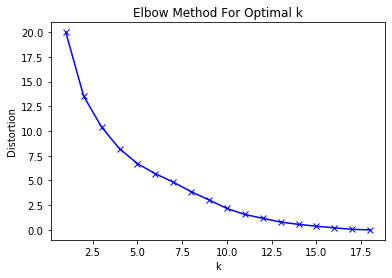

In [76]:
import matplotlib.pyplot as plt
Distortion=[]
K = range(1,19)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(all_for_kmean)
    Distortion.append(km.inertia_)
    
plt.plot(K, Distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

In [63]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_for_kmean)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 3, 7, 6, 3, 5, 3, 0, 3], dtype=int32)

In [64]:
cities_merged.insert(0, 'Cluster Labels', kmeans.labels_)

In [65]:
cities_merged.sort_values(by=['Cluster Labels'])

,Cluster Labels,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,0,1,Bangkok,Thailand,8750600.0,13.7500,100.5166,TH,THA,primary,1.764069e+09,57.15,26.19,56.88,28.14,34.04,170,21.0,Hotel,Convention Center,Cafeteria,Building,Airport
16,0,5,Beijing,China,20700000.0,39.9289,116.3883,CN,CHN,primary,1.156229e+09,44.89,34.97,43.08,35.85,60.72,160,31.0,Hotel,Convention Center,Cafeteria,Building,Airport
15,0,4,Shanghai,China,31100000.0,31.2165,121.4365,CN,CHN,admin,1.156074e+09,50.07,35.67,52.50,36.48,54.40,160,31.0,Hotel,Convention Center,Cafeteria,Building,Airport
13,0,2,Mumbai,India,25000000.0,19.0170,72.8570,IN,IND,admin,1.356227e+09,28.84,21.02,26.86,26.61,41.68,128,63.0,Hotel,Convention Center,Cafeteria,Building,Airport
8,0,19,Chiang Mai,Thailand,1763742.0,18.8000,98.9800,TH,THA,admin,1.764663e+09,46.64,13.13,49.81,22.52,33.90,170,21.0,Hotel,Convention Center,Cafeteria,Building,Airport
17,0,6,Guangzhou,China,48600000.0,23.1450,113.3250,CN,CHN,admin,1.156237e+09,41.26,17.28,42.80,27.95,63.76,160,31.0,Hotel,Convention Center,Cafeteria,Building,Airport
14,1,3,Seoul,South Korea,24800000.0,37.5663,126.9997,KR,KOR,primary,1.410836e+09,85.50,30.45,103.69,45.88,76.81,186,5.0,Hotel,Convention Center,Cafeteria,Building,Airport
12,1,1,Tokyo,Japan,39800000.0,35.6850,139.7514,JP,JPN,primary,1.392686e+09,86.87,38.00,83.42,56.70,89.70,162,29.0,Hotel,Convention Center,Cafeteria,Building,Airport
11,2,0,Delhi,India,46960000.0,37.4306,-120.7759,US,USA,NaN,1.840019e+09,28.18,8.18,26.15,24.76,54.69,128,63.0,Hotel,Airport,Convention Center,Cafeteria,Building
10,2,0,Delhi,India,46960000.0,28.6700,77.2300,IN,IND,admin,1.356873e+09,28.18,8.18,26.15,24.76,54.69,128,63.0,Hotel,Airport,Convention Center,Cafeteria,Building


In [66]:
#create map
maplatitude = 21.03
maplongtitude = 105.8
map_clusters = folium.Map(location=[maplatitude, maplongtitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, Population, cluster, Name, Country, ease in zip(cities_merged['lat'], cities_merged['lng'], cities_merged['Population'], cities_merged['Cluster Labels'],cities_merged['Name'],cities_merged['Country'],cities_merged['Ease of Doing Business']):
    label = folium.Popup(str(Name)+', '+str(Country) + ' Cluster: ' + str(cluster) + ', Ease of Starting business level: ' + str(ease), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=Population/100,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.3).add_to(map_clusters)

In [67]:
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 100px; left: 50px; width: 100px; height: 300px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Cool Legend <br>
                              &nbsp; Cluster 0 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:indigo"></i><br>
                              &nbsp; Cluster 1 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:"></i><br>
                              &nbsp; Cluster 2 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:navy"></i><br>
                              &nbsp; Cluster 3 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                              &nbsp; Cluster 4 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:aqua"></i><br>
                              &nbsp; Cluster 5 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                              &nbsp; Cluster 6 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:yellow"></i><br>
                              &nbsp; Cluster 7 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:orange"></i><br>
                </div>
                ''' 

map_clusters.get_root().html.add_child(folium.Element(legend_html))
map_clusters

### Result: Cluster 0

In [68]:
cities_merged.loc[cities_merged['Cluster Labels'] == 0]

,Cluster Labels,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,0,1,Bangkok,Thailand,8750600.0,13.7500,100.5166,TH,THA,primary,1.764069e+09,57.15,26.19,56.88,28.14,34.04,170,21.0,Hotel,Convention Center,Cafeteria,Building,Airport
8,0,19,Chiang Mai,Thailand,1763742.0,18.8000,98.9800,TH,THA,admin,1.764663e+09,46.64,13.13,49.81,22.52,33.90,170,21.0,Hotel,Convention Center,Cafeteria,Building,Airport
13,0,2,Mumbai,India,25000000.0,19.0170,72.8570,IN,IND,admin,1.356227e+09,28.84,21.02,26.86,26.61,41.68,128,63.0,Hotel,Convention Center,Cafeteria,Building,Airport
15,0,4,Shanghai,China,31100000.0,31.2165,121.4365,CN,CHN,admin,1.156074e+09,50.07,35.67,52.50,36.48,54.40,160,31.0,Hotel,Convention Center,Cafeteria,Building,Airport
16,0,5,Beijing,China,20700000.0,39.9289,116.3883,CN,CHN,primary,1.156229e+09,44.89,34.97,43.08,35.85,60.72,160,31.0,Hotel,Convention Center,Cafeteria,Building,Airport
17,0,6,Guangzhou,China,48600000.0,23.1450,113.3250,CN,CHN,admin,1.156237e+09,41.26,17.28,42.80,27.95,63.76,160,31.0,Hotel,Convention Center,Cafeteria,Building,Airport


### Result: Cluster 1

In [69]:
cities_merged.loc[cities_merged['Cluster Labels'] == 1]

,Cluster Labels,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,1,1,Tokyo,Japan,39800000.0,35.6850,139.7514,JP,JPN,primary,1.392686e+09,86.87,38.00,83.42,56.70,89.70,162,29.0,Hotel,Convention Center,Cafeteria,Building,Airport
14,1,3,Seoul,South Korea,24800000.0,37.5663,126.9997,KR,KOR,primary,1.410836e+09,85.50,30.45,103.69,45.88,76.81,186,5.0,Hotel,Convention Center,Cafeteria,Building,Airport


### Result: Cluster 2

In [70]:
cities_merged.loc[cities_merged['Cluster Labels'] == 2]

,Cluster Labels,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,2,0,Delhi,India,46960000.0,28.6700,77.2300,IN,IND,admin,1.356873e+09,28.18,8.18,26.15,24.76,54.69,128,63.0,Hotel,Airport,Convention Center,Cafeteria,Building
11,2,0,Delhi,India,46960000.0,37.4306,-120.7759,US,USA,NaN,1.840019e+09,28.18,8.18,26.15,24.76,54.69,128,63.0,Hotel,Airport,Convention Center,Cafeteria,Building


### Result: Cluster 3

In [71]:
cities_merged.loc[cities_merged['Cluster Labels'] == 3]

,Cluster Labels,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,0,Jakarta,Indonesia,10135030.0,-6.1744,106.8294,ID,IDN,primary,1.360771e+09,44.48,19.42,45.41,25.06,27.34,118,73.0,Hotel,Convention Center,Cafeteria,Building,Airport
2,3,2,Ho Chi Minh City,Vietnam,7981411.0,10.7800,106.6950,VN,VNM,admin,1.704774e+09,38.20,16.74,36.30,20.71,26.64,121,70.0,Hotel,Convention Center,Cafeteria,Building,Airport
5,3,9,Bandung,Indonesia,2575478.0,-6.9500,107.5700,ID,IDN,admin,1.360313e+09,35.71,9.69,36.86,16.95,25.78,118,73.0,Hotel,Convention Center,Cafeteria,Building,Airport
7,3,18,Manila,Philippines,1780148.0,14.6042,120.9822,PH,PHL,primary,1.608618e+09,38.99,21.33,33.32,25.61,25.14,96,95.0,Hotel,Convention Center,Cafeteria,Building,Airport
9,3,37,Phnom Penh,Cambodia,1242992.0,11.5500,104.9166,KH,KHM,primary,1.116261e+09,46.92,18.23,43.29,26.45,14.56,47,144.0,Hotel,Convention Center,Cafeteria,Building,Airport


In [72]:
cities_merged.loc[cities_merged['Cluster Labels'] == 4]

,Cluster Labels,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18,4,8,Hong Kong,Hong Kong,7300000.0,22.305,114.185,HK,HKG,NaN,1.344983e+09,77.22,79.57,75.94,54.36,65.32,188,3.0,Hotel,Convention Center,Cafeteria,Building,Airport


In [73]:
cities_merged.loc[cities_merged['Cluster Labels'] == 5]

,Cluster Labels,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,5,16,Kuala Lumpur,Malaysia,1808922.0,3.1667,101.7,MY,MYS,primary,1.458989e+09,42.47,15.18,40.77,27.32,67.27,179,12.0,Hotel,Building,Convention Center,Cafeteria,Airport


In [74]:
cities_merged.loc[cities_merged['Cluster Labels'] == 6]

,Cluster Labels,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,6,4,Singapore,Singapore,5399000.0,1.293,103.8558,SG,SGP,primary,1.702341e+09,81.1,63.27,66.75,58.99,88.96,189,2.0,Hotel,Building,Convention Center,Cafeteria,Airport


In [75]:
cities_merged.loc[cities_merged['Cluster Labels'] == 7]

,Cluster Labels,index_x,Name,Country,Population,lat,lng,iso2,iso3,capital,id,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,index_y,Ease of Doing Business,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,7,3,Hanoi,Vietnam,7067000.0,21.0333,105.85,VN,VNM,primary,1.704414e+09,39.88,11.45,39.32,19.69,28.99,121,70.0,Hotel,Cafeteria,Convention Center,Building,Airport
